### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '6y'
predict_change=False

### Load stock data

In [3]:
top100tech = ['AAPL', 'MSFT', 'TSM', 'NVDA', 'INTC', 'ASML', 'ADBE', 'CRM', 'AVGO', 'ORCL', 'CSCO', 'ACN', 'TXN', 'SHOP', 'QCOM', 'SAP', 'SNE', 'AMAT', 'INTU', 'NOW', 'SQ', 'IBM', 'MU', 'AMD',
'UBER', 'FIS', 'LRCX', 'FISV', 'SNOW', 'INFY', 'TEAM', 'ADSK', 'DELL', 'WDAY', 'VMW', 'ADI', 'NXPI', 'KLAC',
'CRWD', 'PLTR', 'DOCU', 'TEL', 'ERIC', 'MCHP', 'CDNS', 'CTSH', 'APH', 'SNPS', 'HPQ',
'PANW', 'OKTA','RNG','STM','MRVL','XLNX','WIT','MSI','SWKS','GLW','DDOG','ANSS','U','ZS','FTNT','STNE','ZBRA','KEYS','FTV','MXIM','COUP','GRMN','SPLK','HUBS','WORK','NET','FLT','CDW','CAJ','AFRM','PAYC','TER',
'VRSN','WDC', 'ZI', 'UMC','ANET','EPAM', 'UI','XM',
'GIB','TRMB', 'TYL','WIX','HPE','LYFT', 'LOGI', 'MPWR']
top10tech = top100tech[:10]

In [4]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [5]:
traditional_energy_stocks = [
    "LNG",
    "OKE",
    "BKR",
    "WMB",
    "EQT", 
    "XEC", 
    "XOM", 
    "CVX", 
    "BP", 
    "OXY", 
    "COP", 
    "EOG", 
    "COG", 
    "CNQ", 
    "SLB", 
    "PTR", 
    "TOT", 
    "ENB",  
]

In [6]:
top_green = ['CSIQ', 'SPWR', 'AQN.TO', 'DQ', 
            'HYSR', # HYSR has a lot of days where the prices don't change, causes nan indicators
             'PLUG', 'SOL', 'NEE', 'ENPH', 'FSLR', 'SEDG', 'ORA']

In [7]:
ev_battery_stocks = ["TSLA", "WKHS", "BLNK", "LAC", "MG", "KNDI", "NFI.TO", "BLDP", "AYRO"]

In [8]:
data = get_data_yf(ev_battery_stocks, time_period)

[*********************100%***********************]  9 of 9 completed


In [9]:
data.shape

(1537, 45)

In [10]:
data = data.dropna()

In [11]:
data.shape

(1481, 45)

In [12]:
data.isna().sum().sum()

0

In [13]:
data = process_stock_data_from_yf(data)

In [14]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

In [15]:
data

,Ticker,Date,Close,High,Low,Open,Volume
0,AYRO,2015-04-02,475.200012,501.600006,475.200012,501.600006,46.0
1,AYRO,2015-04-06,501.600006,528.000000,448.799988,528.000000,61.0
2,AYRO,2015-04-07,528.000000,528.000000,448.799988,528.000000,76.0
3,AYRO,2015-04-08,501.600006,528.000000,448.799988,528.000000,55.0
4,AYRO,2015-04-09,712.799988,739.200012,580.799988,633.599976,1403.0
...,...,...,...,...,...,...,...
13324,WKHS,2021-03-26,13.450000,14.300000,12.870000,13.730000,13457600.0
13325,WKHS,2021-03-29,12.930000,13.430000,12.600000,13.378000,9756800.0
13326,WKHS,2021-03-30,13.400000,13.410000,12.400000,12.940000,8341900.0
13327,WKHS,2021-03-31,13.770000,14.070000,13.390000,13.900000,11405700.0


### Compute technical indicators

In [16]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

### Load climate trends data

In [17]:
filenames = [os.path.join("data", x) for x in [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
] ]
filenames2 = [
    "data climate change.csv",
    "data greenhouse gas.csv",
    "data oil.csv",
    "data renewable.csv",
    "data carbon tax.csv",
    "data electric vehicles.csv",
    "data environmental protection agency.csv",
    "data fossil fuels.csv",
    "data fracking.csv",
    "data global warming.csv",
]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [18]:
climate_trends_data = load_climate_data(filenames, terms)

In [19]:
climate_trends_data.isna().sum()

Term
Date                               0
carbon tax                         0
climate change                     0
electric vehicles                  0
environmental protection agency    0
fossil fuels                       0
fracking                           0
global warming                     0
greenhouse gas                     0
oil                                0
renewable                          0
dtype: int64

In [20]:
term_scaler = StandardScaler()
climate_trends_data[terms] = term_scaler.fit_transform(climate_trends_data[terms])

In [21]:
climate_trends_data.isna().sum()

Term
Date                               0
carbon tax                         0
climate change                     0
electric vehicles                  0
environmental protection agency    0
fossil fuels                       0
fracking                           0
global warming                     0
greenhouse gas                     0
oil                                0
renewable                          0
dtype: int64

In [22]:
climate_trends_data 

Term,Date,carbon tax,climate change,electric vehicles,environmental protection agency,fossil fuels,fracking,global warming,greenhouse gas,oil,renewable
0,2015-01-01,-0.788948,-1.295522,-1.139177,-0.382898,-1.226053,-0.117790,-0.752613,0.312173,-2.575343,-1.684594
1,2015-01-02,-0.635418,-1.421787,-1.139177,-0.382898,-0.801345,-0.117790,-0.272482,2.532143,-0.837891,-1.330134
2,2015-01-03,-0.635418,-1.169257,-1.006716,-0.382898,-0.942915,-0.117790,-0.656587,0.723279,-0.837891,-1.684594
3,2015-01-04,-0.788948,-1.169257,-1.072946,-0.382898,0.260424,-0.117790,-0.272482,1.627711,-1.334306,-1.566441
4,2015-01-05,-0.635418,-0.664196,-0.808024,-0.382898,-0.376638,-0.117790,0.015597,0.805500,0.403146,-0.798443
...,...,...,...,...,...,...,...,...,...,...,...
2273,2021-03-23,-0.021297,-0.411665,0.052973,0.616233,0.260424,0.232963,-0.752613,0.229952,-1.334306,0.501244
2274,2021-03-24,-0.021297,-0.285400,0.251664,1.199059,-0.022714,0.232963,-0.368508,0.476615,-0.837891,0.501244
2275,2021-03-25,2.281654,-0.285400,0.715278,2.697754,0.260424,0.232963,-0.176456,0.229952,-1.086098,0.501244
2276,2021-03-26,1.514004,-0.411665,0.582817,0.699494,0.048070,0.232963,-0.656587,0.065510,-0.837891,-0.325830


In [23]:
num_climate_features = len(climate_trends_data.columns.tolist()) - 1 # minus date

<AxesSubplot:xlabel='Date'>

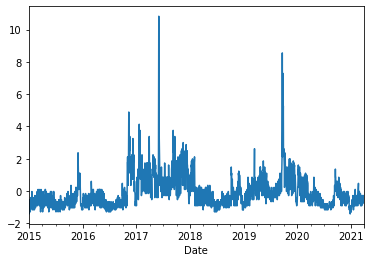

In [24]:
climate_trends_data.set_index('Date')['climate change'].plot()

### Choose features

In [25]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 
    #'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 
    # 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

### Normalization
We want to normalize the prices, and there are two challenges
1. We want to be able to recover performance metrics like RMSE in dollars, so we have to have the saved transforms for closing price to un transform after prediction. 
2. We will want to normalize each different company differently, because the stocks will be of differing magnitudes
3. We only want to fit normalizing model on train and validation

### Train test split

In [26]:
train = dataset.loc[dataset['Date'] < "2018-03-01"]
valid = dataset.loc[(dataset['Date'] > "2018-03-13") & (dataset['Date'] < "2019-03-01")]
test = dataset.loc[(dataset['Date'] > "2019-03-01") & (dataset['Date'] < "2020-03-01")]

### Correlations

In [27]:
trainvalid = dataset.loc[dataset['Date'] < "2019-03-01"]
trainvalid = trainvalid.merge(climate_trends_data, on=["Date"], how='left')
trainvalid['Target'] = trainvalid['Close'].shift(-predict_length)
trainvalid['Change'] = trainvalid['Target'] - trainvalid['Close']

In [28]:
s = traditional_energy_stocks[0]

#### Correlations with google trends stats on change in price

In [29]:
cor_by_stock = trainvalid.groupby('Ticker').apply(lambda x: x.corr().loc['Change']).T

In [30]:
terms_cor_by_stock = cor_by_stock.loc[terms]

In [31]:
terms_cor_by_stock.style.apply(lambda x: ["background: yellow" if abs(v) > 0.1 else "" for v in x], axis = 1)

Ticker,AYRO,BLDP,BLNK,KNDI,LAC,MG,NFI.TO,TSLA,WKHS
Change,,,,,,,,,
climate change,-0.003812,0.021390,-0.021528,0.043305,0.039144,0.028471,0.067587,0.049699,0.010282
greenhouse gas,-0.235786,-0.006793,0.018624,-0.094279,0.011259,0.007453,0.070105,0.028412,0.007250
oil,0.134598,0.056159,0.080009,0.003279,0.042016,-0.027372,-0.045476,-0.006936,-0.039958
renewable,0.066510,0.012005,0.000035,0.053818,0.018333,-0.006488,0.073291,0.029314,-0.038872
carbon tax,0.119722,0.005909,-0.015229,0.018078,0.019162,-0.079718,0.028211,0.076139,-0.097935
electric vehicles,0.030906,0.136932,0.036370,0.008872,0.117889,-0.092801,-0.126481,-0.119178,-0.026184
environmental protection agency,nan,nan,nan,nan,nan,nan,nan,nan,nan
fossil fuels,-0.111335,0.026394,-0.008720,0.038322,0.026178,-0.013007,0.001848,-0.030323,0.042350
fracking,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [32]:
trends_cors = abs(terms_cor_by_stock).mean(axis=1).sort_values(ascending=False)
trends_cors.name = "Mean Absolute Pearson Correlation to Change"
trends_cors.index.name = "Feature"

In [33]:
pd.DataFrame(trends_cors)

,Mean Absolute Pearson Correlation to Change
Feature,
electric vehicles,0.077290
greenhouse gas,0.053329
carbon tax,0.051122
global warming,0.048464
oil,0.048423
renewable,0.033185
fossil fuels,0.033164
climate change,0.031691
environmental protection agency,NaN


In [34]:
best_trends_features = trends_cors.index.tolist()[:8]

In [35]:
best_trends_features

['electric vehicles',
 'greenhouse gas',
 'carbon tax',
 'global warming',
 'oil',
 'renewable',
 'fossil fuels',
 'climate change']

#### Correlations with technical indicators to change in price

In [36]:
cor_by_stock = trainvalid.groupby('Ticker').apply(lambda x: x.corr().loc['Change']).T
terms_cor_by_stock = cor_by_stock.loc[features]

In [37]:
terms_cor_by_stock.style.apply(lambda x: ["background: yellow" if abs(v) > 0.1 else "" for v in x], axis = 1)

Ticker,AYRO,BLDP,BLNK,KNDI,LAC,MG,NFI.TO,TSLA,WKHS
Change,,,,,,,,,
Close,-0.341468,0.050420,-0.190081,-0.228667,-0.045984,-0.110396,-0.134298,-0.140503,-0.115480
High,-0.358146,0.048408,-0.176478,-0.230858,-0.045926,-0.108788,-0.134078,-0.136025,-0.122790
Low,-0.317284,0.052915,-0.191488,-0.229266,-0.045913,-0.107398,-0.134870,-0.141124,-0.110956
Open,-0.320584,0.049727,-0.182904,-0.230751,-0.045695,-0.102210,-0.133833,-0.135729,-0.117142
Volume,-0.119872,-0.037466,0.024241,-0.142949,0.007598,0.059106,-0.026484,0.011174,-0.081664
HH,-0.349341,0.038267,-0.174359,-0.221016,-0.050117,-0.076960,-0.135559,-0.105320,-0.106233
LL,-0.288494,0.046262,-0.186524,-0.186478,-0.048941,-0.104074,-0.138419,-0.137146,-0.106243
AV,-0.059137,-0.046067,0.038665,-0.453688,0.022302,0.158174,-0.062322,-0.008715,-0.039780
SMA,-0.312749,0.046378,-0.185635,-0.188949,-0.054603,-0.090998,-0.139476,-0.121376,-0.106556


In [38]:
indicator_cors = abs(terms_cor_by_stock).mean(axis=1).sort_values(ascending=False)
indicator_cors.name = "Mean Absolute Pearson Correlation to Change"
indicator_cors.index.name = "Feature"

In [39]:
best_technical_features = [
    "WMA",
    "Close",
    "Low",
    "High",
    "ADX"
]

In [40]:
trainvalid.loc[trainvalid['Ticker']==s].corr().loc['Change'].sort_values(key=abs, ascending=False)

Close                             NaN
High                              NaN
Low                               NaN
Open                              NaN
Volume                            NaN
HH                                NaN
LL                                NaN
AV                                NaN
SMA                               NaN
SD                                NaN
ATR                               NaN
DMH                               NaN
DML                               NaN
EMA                               NaN
WMA                               NaN
BBHIGH                            NaN
BBLOW                             NaN
PERBHIGH                          NaN
PERBLOW                           NaN
TRIMA                             NaN
RSI                               NaN
PDI                               NaN
NDI                               NaN
ADX                               NaN
ROC                               NaN
MACD                              NaN
CCI         

<AxesSubplot:>

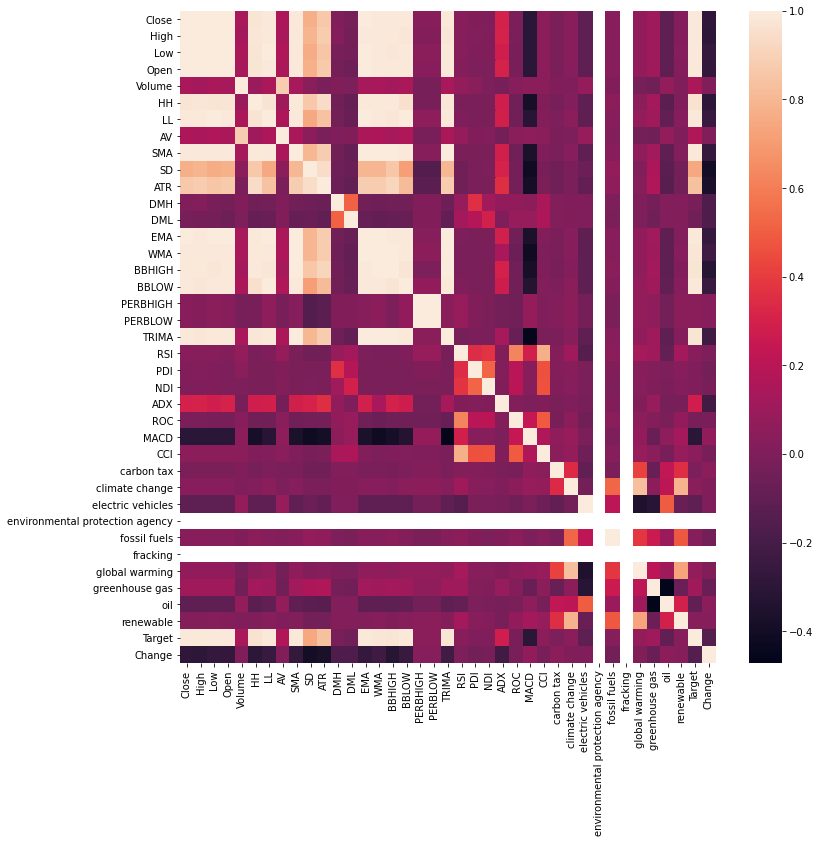

In [41]:
plt.figure(figsize=(12, 12))
sns.heatmap(trainvalid.corr())

# Results of Correlations

In [42]:
pd.DataFrame(trends_cors)

,Mean Absolute Pearson Correlation to Change
Feature,
electric vehicles,0.077290
greenhouse gas,0.053329
carbon tax,0.051122
global warming,0.048464
oil,0.048423
renewable,0.033185
fossil fuels,0.033164
climate change,0.031691
environmental protection agency,NaN


In [43]:
pd.DataFrame(indicator_cors)

,Mean Absolute Pearson Correlation to Change
Feature,
High,0.151277
Close,0.150811
Low,0.147913
Open,0.146508
EMA,0.140572
BBHIGH,0.140351
HH,0.139686
SMA,0.138525
LL,0.138064


#### Per stock normalization
We make sure to fit the transforms on the training, and
apply them on training, validation, and test

In [73]:
scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is tryin

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is tryin

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


### Merge in the climate data

In [34]:
climate_trends_data.isna().sum()

Term
Date                               0
carbon tax                         0
climate change                     0
electric vehicles                  0
environmental protection agency    0
fossil fuels                       0
fracking                           0
global warming                     0
greenhouse gas                     0
oil                                0
renewable                          0
dtype: int64

In [35]:
climate_trends_data[climate_trends_data['Date']=='2015-09-02']

Term,Date,carbon tax,climate change,electric vehicles,environmental protection agency,fossil fuels,fracking,global warming,greenhouse gas,oil,renewable
244,2015-09-02,-0.481888,-0.53793,-1.006716,-0.382898,-0.093499,-0.11779,0.015597,-0.756701,0.154939,0.028631


In [36]:
train = train.merge(climate_trends_data, on=["Date"], how='left')
valid = valid.merge(climate_trends_data, on=["Date"], how='left')
test = test.merge(climate_trends_data, on=["Date"], how='left')

In [37]:
train[train[terms].isna().sum(axis=1)>0]

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI,carbon tax,climate change,electric vehicles,environmental protection agency,fossil fuels,fracking,global warming,greenhouse gas,oil,renewable


In [38]:
train.isna().sum()

Ticker                               0
Date                                 0
Close                                0
High                                 0
Low                                  0
Open                                 0
Volume                               0
HH                                   0
LL                                   0
AV                                   0
SMA                                  0
SD                                  11
WILLR                                0
ATR                                  0
DMH                                  0
DML                                  0
EMA                                  0
WMA                                143
BBHIGH                              11
BBLOW                               11
PERBHIGH                            11
PERBLOW                             11
TRIMA                              143
RSI                                154
DX                                  59
PDI                      

#### Prepare training inputs and outputs
Convert the daily data points into a set of data points each with {trail_size} days.   
We keep track of the tickers so we can later inverse the normalization with the right model. 

In [39]:
# valid.groupby('Ticker').apply(lambda x: apply_rolling(x, trail_size=trail_size, predict_length=predict_length, predict_change=predict_change))

In [40]:
# apply_rolling(valid.loc[valid['Ticker']=='HYSR'], trail_size, predict_length, predict_change)

In [41]:
# valid.loc[valid['Ticker']=='HYSR']

In [42]:
# valid.loc[valid['Ticker']=='HYSR'].isna().sum(axis=0)

In [43]:
x_train, y_train, tickers_train = roll_all_stocks(train, trail_size, predict_length, predict_change=predict_change)
x_valid, y_valid, tickers_valid = roll_all_stocks(valid, trail_size, predict_length, predict_change=predict_change)
x_test, y_test, tickers_test = roll_all_stocks(test, trail_size, predict_length, predict_change=predict_change)

[(688, 14, 39), (688, 14, 39), (688, 14, 39), (587, 14, 39), (688, 14, 39), (688, 14, 39), (688, 14, 39), (512, 14, 39), (646, 14, 39), (463, 14, 39), (688, 14, 39)]
[(219, 14, 39), (219, 14, 39), (219, 14, 39), (219, 14, 39), (219, 14, 39), (219, 14, 39), (219, 14, 39), (177, 14, 39), (219, 14, 39), (182, 14, 39), (205, 14, 39)]
[(228, 14, 39), (228, 14, 39), (228, 14, 39), (228, 14, 39), (228, 14, 39), (228, 14, 39), (228, 14, 39), (214, 14, 39), (228, 14, 39), (127, 14, 39), (228, 14, 39)]


In [44]:
num_features+=num_climate_features

#### Confirm shapes

In [45]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (7024, 14, 39)
y_train: (7024,)
x_valid: (2316, 14, 39)
y_valid (2316,)
x_test: (2393, 14, 39)
y_test (2393,)


In [46]:
print("tickers_train: {}".format(tickers_train.shape))
print("tickers_train: {}".format(tickers_valid.shape))
print("tickers_train: {}".format(tickers_test.shape))

tickers_train: (7024,)
tickers_train: (2316,)
tickers_train: (2393,)


### Model design

In [47]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            34500     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 420)               0

In [49]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [50]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train on many stocks

In [51]:
history1 = model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), batch_size=64, shuffle=False, callbacks=[tensorboard])

Epoch 1/100
110/110 [==============================] - 8s 31ms/step - loss: 0.0873 - val_loss: 0.0299
Epoch 2/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0212 - val_loss: 0.0238
Epoch 3/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0121 - val_loss: 0.0222
Epoch 4/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0106 - val_loss: 0.0235
Epoch 5/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0098 - val_loss: 0.0221
Epoch 6/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0090 - val_loss: 0.0230
Epoch 7/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0090 - val_loss: 0.0236
Epoch 8/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0090 - val_loss: 0.0240
Epoch 9/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0082 - val_loss: 0.0250
Epoch 10/100
110/110 [==============================] - 1s 10ms/step - loss: 0.007

### Prepare data for one stock

In [52]:
target_stock = 'FSLR'

In [53]:
single_stock_dataset = dataset[dataset['Ticker']==target_stock].reset_index(drop=True)

<AxesSubplot:xlabel='Date', ylabel='Close'>

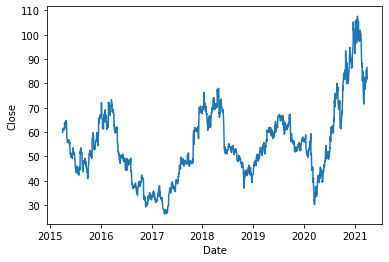

In [54]:
sns.lineplot(x=single_stock_dataset['Date'], y=single_stock_dataset['Close'])

### Train test split

In [55]:
train = single_stock_dataset.loc[single_stock_dataset['Date'] < "2018-03-01"]
valid = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2018-03-13") & (single_stock_dataset['Date'] < "2019-03-01")]
test = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2019-03-01") & (single_stock_dataset['Date'] < "2020-03-01")]

In [56]:
single_stock_scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is tryin

In [57]:
train = train.merge(climate_trends_data, on=["Date"], how='left')
valid = valid.merge(climate_trends_data, on=["Date"], how='left')
test = test.merge(climate_trends_data, on=["Date"], how='left')

#### Prepare training inputs and outputs
Since we are using just one stock, we don't need to keep track of tickers

In [58]:
x_train, y_train, _ = roll_all_stocks(train, trail_size, predict_length, predict_change=predict_change)
x_valid, y_valid, _ = roll_all_stocks(valid, trail_size, predict_length, predict_change=predict_change)
x_test, y_test, _ = roll_all_stocks(test, trail_size, predict_length, predict_change=predict_change)

[(688, 14, 39)]
[(219, 14, 39)]
[(228, 14, 39)]


#### Confirm shapes

In [59]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (688, 14, 39)
y_train: (688,)
x_valid: (219, 14, 39)
y_valid (219,)
x_test: (228, 14, 39)
y_test (228,)


### Test model on single stock

In [60]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), 
                                                      y_train,
                                                     num_features - num_climate_features,
                                                     single_stock_scaler_models[target_stock])))

Training RMSE = 2.5551112727311183


In [61]:
print("Validation RMSE = {}".format(evaluate_model_rmse(model.predict(x_valid), 
                                                      y_valid,
                                                     num_features - num_climate_features,
                                                     single_stock_scaler_models[target_stock])))

Validation RMSE = 9.034309084021501


In [62]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), 
                                                     y_test,
                                                    num_features - num_climate_features,
                                                    single_stock_scaler_models[target_stock])))

Testing RMSE = 11.689008579993796


In [63]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            34500     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 420)               0

In [65]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train model on single stock

In [66]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [67]:
history2 = model.fit(x_train, y_train, epochs=45, validation_data=(x_valid, y_valid), batch_size=64, shuffle=False, callbacks=[tensorboard])

Epoch 1/45
11/11 [==============================] - 7s 403ms/step - loss: 0.0036 - val_loss: 0.0373
Epoch 2/45
11/11 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 0.0218
Epoch 3/45
11/11 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0295
Epoch 4/45
11/11 [==============================] - 0s 12ms/step - loss: 0.0032 - val_loss: 0.0202
Epoch 5/45
11/11 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 0.0282
Epoch 6/45
11/11 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0231
Epoch 7/45
11/11 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.0334
Epoch 8/45
11/11 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0242
Epoch 9/45
11/11 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0327
Epoch 10/45
11/11 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0233
Epoch 11

### Visualize results

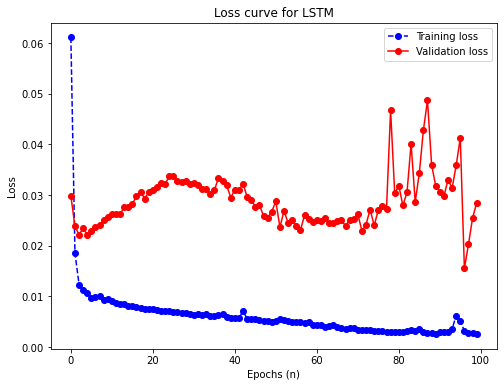

In [68]:
plot_loss(history1)

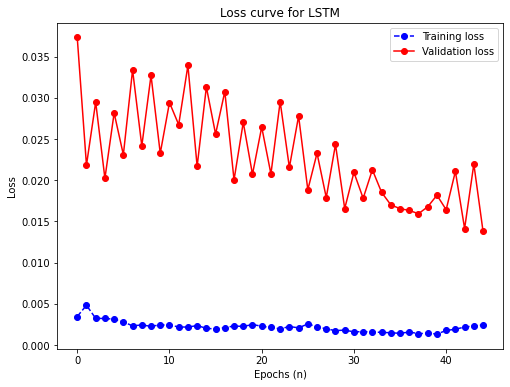

In [69]:
plot_loss(history2)

In [70]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), 
                                                      y_train,
                                                     num_features - num_climate_features,
                                                     single_stock_scaler_models[target_stock])))

Training RMSE = 2.1426348751831927


In [71]:
print("Validation RMSE = {}".format(evaluate_model_rmse(model.predict(x_valid), 
                                                      y_valid,
                                                     num_features - num_climate_features,
                                                     single_stock_scaler_models[target_stock])))

Validation RMSE = 5.863926254926311


In [72]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), 
                                                     y_test,
                                                    num_features - num_climate_features,
                                                    single_stock_scaler_models[target_stock])))

Testing RMSE = 6.731191235572031


#### Compare to simple baseline

In [73]:
def predict_no_change(x, predict_change=False):
    if predict_change:
        return 0
    else:
        return x[-1][0]

In [74]:
no_change_preds = np.array([predict_no_change(x, predict_change=predict_change) for x in x_train])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [75]:
evaluate_model_rmse(no_change_preds, y_train, num_features - num_climate_features, single_stock_scaler_models[target_stock])

3.2108639733005924

In [76]:
no_change_preds = np.array([predict_no_change(x, predict_change=predict_change) for x in x_valid])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [77]:
evaluate_model_rmse(no_change_preds, y_valid, num_features - num_climate_features, single_stock_scaler_models[target_stock])

3.30124204798213

In [78]:
no_change_preds = np.array([predict_no_change(x, predict_change=predict_change) for x in x_test])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [79]:
evaluate_model_rmse(no_change_preds, y_test, num_features - num_climate_features, single_stock_scaler_models[target_stock])

2.9398516313166847

### Plot data against predictions

<AxesSubplot:title={'center':'Training performance'}>

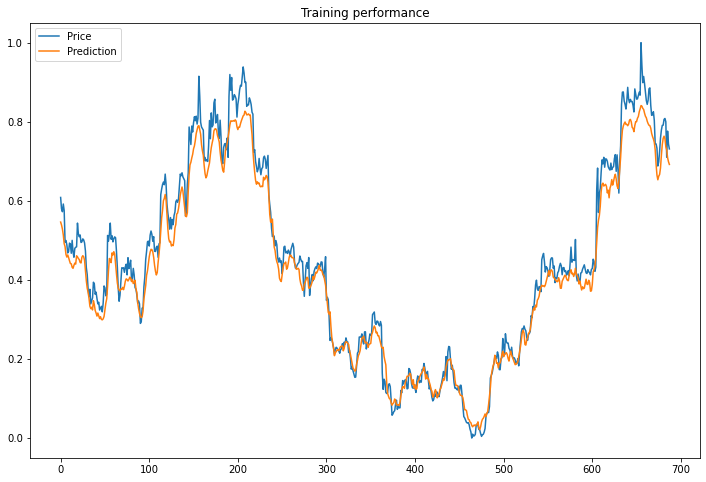

In [80]:
price_vs_preds = pd.DataFrame([y_train, model.predict(x_train)[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Training performance")

<AxesSubplot:title={'center':'Validation performance'}>

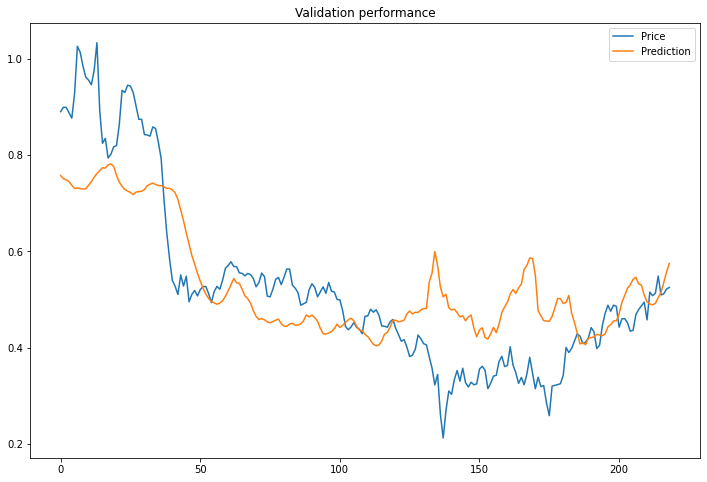

In [81]:
price_vs_preds = pd.DataFrame([y_valid, model.predict(x_valid)[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Validation performance")

<AxesSubplot:title={'center':'Testing performance'}>

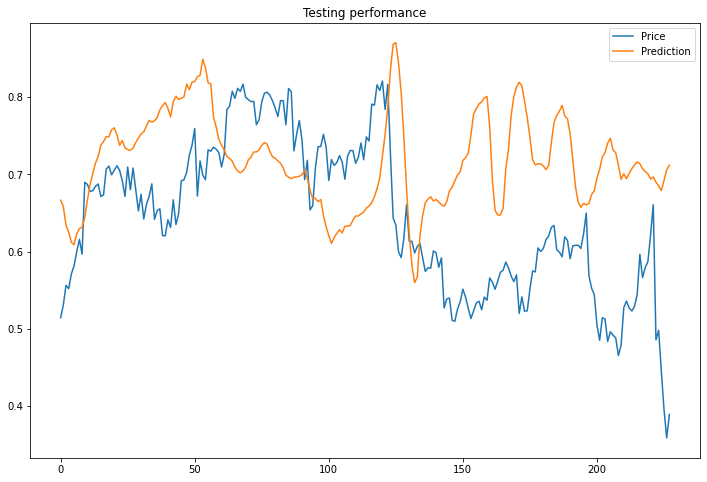

In [82]:
price_vs_preds = pd.DataFrame([y_test, model.predict(x_test)[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Testing performance")